In [2]:
import kwant
import matplotlib.pyplot as plt
import numpy as np
import scipy.sparse.linalg as sla
from ccode.boundstate import find_boundstates, extract_boundstates
import time

%matplotlib inline
plt.rcParams.update({"font.size": 12})

In [3]:
def sort_eigen(ev):
    """
    Sort eigenvectors and eigenvalues using numpy methods.
    """
    evals, evecs = ev
    idx = np.argsort(evals)
    evals = evals[idx]
    evecs = evecs[:, idx]
    return evals, evecs.T

In [4]:
# Hamiltonian of the system
majorana_hamiltonian = """
    ( t * (k_x**2 + k_y**2 ) - mu) * kron(sigma_0, sigma_z)
    + alpha * k_x * kron(sigma_y, sigma_z)
    - alpha * k_y * kron(sigma_x, sigma_z)
    + Delta * kron(sigma_0, sigma_x)
    + B_x * kron(sigma_x, sigma_0)
"""
a = 1
template = kwant.continuum.discretize(majorana_hamiltonian)

/tmp/ipykernel_460/898861703.py:10: KwantDeprecationWarning: Accessing kwant.continuum without an explicit import is deprecated. Instead, explicitly 'import kwant.continuum'.
  template = kwant.continuum.discretize(majorana_hamiltonian)
/opt/conda/lib/python3.9/site-packages/sympy/__init__.py:672: SymPyDeprecationWarning: 

importing sympy.matrices.matrices with 'from sympy import *' has been
deprecated since SymPy 1.6. Use import sympy.matrices.matrices
instead. See https://github.com/sympy/sympy/issues/18245 for more
info.

  self.Warn(
/opt/conda/lib/python3.9/site-packages/sympy/__init__.py:672: SymPyDeprecationWarning: 

importing sympy.matrices.matrices with 'from sympy import *' has been
deprecated since SymPy 1.6. Use import sympy.matrices.matrices
instead. See https://github.com/sympy/sympy/issues/18245 for more
info.

  self.Warn(


In [5]:
def interval_shape(L, W):
    def shape(site):
        return 0 <= site.pos[0] < L and 0 <= site.pos[1] < W
    return shape


def make_junction(L, W):
    junction = kwant.Builder()
    junction.fill(
        template,
        shape=interval_shape(L, W),
        start=[0,0]
    )
    return junction

### Infinite system

In [6]:
L = 20
W = 3
rectangle = make_junction(L, W)

In [7]:
lead = kwant.Builder(symmetry=kwant.TranslationalSymmetry([-1, 0]))
lead.fill(template, shape=lambda site: 0 <= site.pos[1] < W, start=[0, 0]);
rectangle.attach_lead(lead)
rectangle = rectangle.finalized()

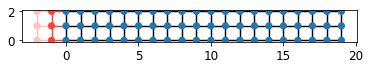

In [8]:
kwant.plot(rectangle);

In [9]:
params = {
    't': 1,
    'mu': 0.3,
    'alpha': 0.3,
    'Delta': 0.3,
    'B_x': 0.5
}

In [10]:
%%time
start = time.time()
en, vec = find_boundstates(syst=rectangle,
                           min_energy=-0.01,
                           max_energy=0.01,
                           sparse=True,
                           params=params,
                           rtol=1e-1
                          )
end = time.time()
print(end-start)

0.00016880035400390625
CPU times: user 1.28 ms, sys: 44 µs, total: 1.32 ms
Wall time: 1.03 ms


In [27]:
%%time
inf_ens = []
inf_vecs = []
Bs = np.linspace(0, 1, 100)
print('Evaluation time of find_boundstates in seconds:')
for b in Bs:
    params['B_x'] = b
    start = time.time()
    en, vec = find_boundstates(syst=rectangle,
                               min_energy=-0.01,
                               max_energy=0.01,
                               sparse=True,
                               params=params,
                               rtol=1e-2
                              )
    end = time.time()
    print(end-start)
    inf_ens.append(en)
    inf_vecs.append(vec)

Evaluation time of find_boundstates in seconds:
1.3838005065917969
1.0052051544189453
0.9677796363830566
0.9940352439880371
1.141470193862915
1.1119341850280762
1.0710456371307373
1.052232265472412
1.136671781539917
0.9825315475463867
0.9858982563018799
0.9940485954284668
1.1646604537963867
0.9545185565948486
1.0507843494415283
1.0693583488464355
1.1499788761138916
1.1831896305084229
1.1229543685913086
1.1035261154174805
1.1274726390838623
1.10329270362854
1.127338171005249
1.1109797954559326
1.1404459476470947
1.141777753829956
1.107722520828247
1.1069178581237793
1.1078410148620605
1.1941063404083252
1.114626407623291
1.101923942565918
1.1834022998809814
1.1979761123657227
1.2820396423339844
1.251330852508545
1.1107001304626465
1.1173300743103027
1.022085428237915
0.8021292686462402
0.1578693389892578
0.16062283515930176
0.1552736759185791
0.1587810516357422
0.15648508071899414
0.15693998336791992
0.16102910041809082
0.17287373542785645
0.17705059051513672
0.17972946166992188
0.17354

In [28]:
w = np.where(np.abs(inf_ens)>0)[0][0]

/tmp/ipykernel_460/149243906.py:1: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  w = np.where(np.abs(inf_ens)>0)[0][0]
/tmp/ipykernel_460/149243906.py:1: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  w = np.where(np.abs(inf_ens)>0)[0][0]


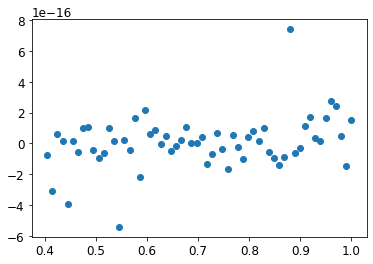

In [29]:
plt.scatter(Bs[w:], inf_ens[w:])

In [30]:
density = kwant.operator.Density(rectangle, np.eye(4))

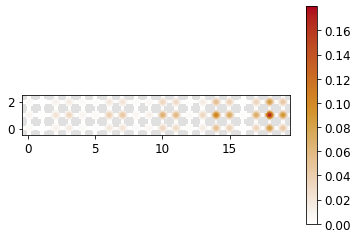

/tmp/ipykernel_460/3505946799.py:1: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  kwant.plotter.density(rectangle, density(inf_vecs[-8][:, 0]));


In [31]:
kwant.plotter.density(rectangle, density(inf_vecs[-8][:, 0]));

In [32]:
%%time
inf_vecs_0 = []
for b in Bs:
    params['B_x'] = b
    vec = extract_boundstates(syst=rectangle,
                             energy=0,
                             sparse=True,
                             params=params
                             )
    inf_vecs_0.append(vec)

CPU times: user 3.88 s, sys: 6 ms, total: 3.89 s
Wall time: 3.88 s


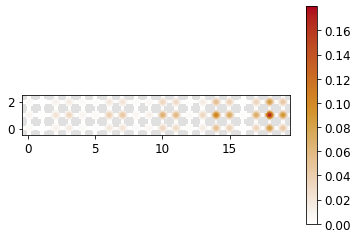

/tmp/ipykernel_460/3773561603.py:1: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  kwant.plotter.density(rectangle, density(inf_vecs_0[-8][:240, 0]));


In [33]:
kwant.plotter.density(rectangle, density(inf_vecs_0[-8][:240, 0]));

#### Notes on bound state algorithm:
* `fing_boundstates` takes longer when there's no bound state in the system.
* `extract_boundstate` is the fastest, but requires providing the energy.

### Finite system

In [34]:
params = {
    't': 1,
    'mu': 0.3,
    'alpha': 0.3,
    'Delta': 0.3,
    'B_x': 0.011
}

In [35]:
finite_wire = make_junction(100, 3).finalized()

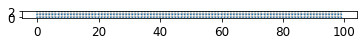

In [36]:
kwant.plot(finite_wire);

In [37]:
%%time
fin_ens = []
fin_vecs = []
for b in Bs:
    params['B_x'] = b
    ham = finite_wire.hamiltonian_submatrix(sparse=True, params=params)
    val, vec = sort_eigen(sla.eigsh(ham.tocsc(), k=10, sigma=0))
    fin_ens.append(val)
    fin_vecs.append(vec)

CPU times: user 6.36 s, sys: 8.97 ms, total: 6.37 s
Wall time: 6.36 s


In [38]:
fin_ens = np.array(fin_ens)

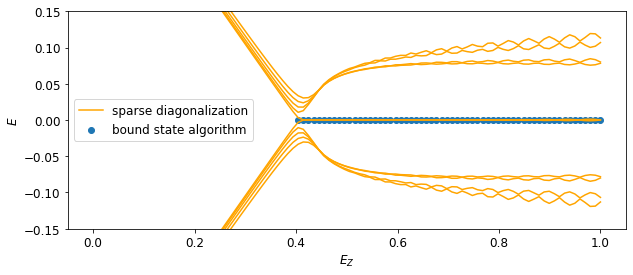

In [42]:
fig, ax = plt.subplots(figsize=(10, 4))
for level in fin_ens.T:
    ax.plot(Bs, level, label='sparse diagonalization', c='orange')
ax.scatter(Bs[w:], inf_ens[w:], label='bound state algorithm')
ax.set_ylim(-0.15, 0.15)
ax.set_ylabel('$E$')
ax.set_xlabel(r'$E_Z$')

handles, labels = plt.gca().get_legend_handles_labels()
by_label = dict(zip(labels, handles))
plt.legend(by_label.values(), by_label.keys(), loc='center left')

In [40]:
density = kwant.operator.Density(finite_wire, np.eye(4))

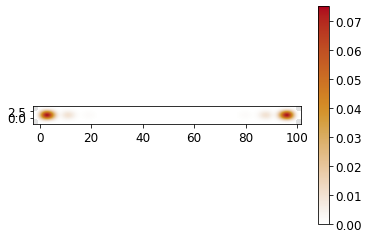

/tmp/ipykernel_460/3342805614.py:1: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  kwant.plotter.density(finite_wire, density(fin_vecs[50][5]));


In [41]:
kwant.plotter.density(finite_wire, density(fin_vecs[50][5]));